In [5]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.interval_based import CanonicalIntervalForest
from sktime.classification.dictionary_based import MUSE
from sktime.transformations.series.sax import SAX
from sktime.transformations.series.paa import PAA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, rbf_kernel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [12]:
tracks_dataset_grouped_genres = pd.read_csv('dataset/tabular/tracks_dataset_without_outliers.csv')

#drop unnamed: 0 column
tracks_dataset_grouped_genres = tracks_dataset_grouped_genres.drop(columns=['Unnamed: 0'])
# conversion to a list
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: x.replace('[','').replace(']','').replace('\'','').split(','))
# keeping only the first genre
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: x[0])

# dropping useless attributes from the dataset
tracks_dataset_grouped_genres = tracks_dataset_grouped_genres.drop(columns=['id', 'name', 'artists', 'album_name', 'n_bars', 'month', 'day'])

# one-hot encode explicit attribute with 0 and 1 in the same column
tracks_dataset_grouped_genres['explicit'] = tracks_dataset_grouped_genres['explicit'].apply(lambda x: 1 if x == True else 0)

# Convert to lowercase for case-insensitive matching
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].str.lower()

# Grouping similar genres by checking if the keyword is contained in the label
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: 'rock' if any(kw in x for kw in ['rock', 'punk', 'alternative','garage', 'grunge', 'ska']) else x)
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: 'metal' if any(kw in x for kw in ['metal', 'grindcore']) else x)
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: 'pop' if any(kw in x for kw in ['pop', 'r&b', 'soul', 'funk', 'reggae', 'r-n-b']) else x)
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: 'electronic' if any(kw in x for kw in ['electronic', 'house', 'techno', 'trance','electro','dub', 'dubstep', 'industrial', 'drum-and-bass']) else x)
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: 'hip-hop' if any(kw in x for kw in ['hip-hop', 'rap', 'trap', 'grime']) else x)
#tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: 'jazz' if any(kw in x for kw in ['jazz', 'blues', 'country', 'folk', 'classical']) else x)
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: 'national' if any(kw in x for kw in ['british', 'swedish', 'spanish', 'brazil', 'indian', 'iranian', 'german', 'french', 'turkish']) else x)

# Convert back to title case for consistency
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].str.title()

# Print unique genres to verify
print(tracks_dataset_grouped_genres['genre'].unique())

# count records in tracks_dataset_grouped_genres
print(tracks_dataset_grouped_genres['genre'].value_counts())

# remove all records with genre different from electronic, pop, national, rock, metal or jazz
tracks_dataset_grouped_genres = tracks_dataset_grouped_genres[tracks_dataset_grouped_genres['genre'].isin(['Electronic', 'Pop', 'National', 'Rock', 'Metal'])]

print(tracks_dataset_grouped_genres['genre'].value_counts())


['Pop' 'Indie' 'Hip-Hop' 'Songwriter' 'Rock' 'Electronic' 'Country'
 'Dance' 'Metal' 'Latino' 'Folk' 'Latin' 'Piano' 'Emo' 'Chill' 'National'
 'Blues' 'Sad' 'Edm' 'Hardcore' 'Disco' 'Acoustic' 'Dancehall' 'J-Dance'
 'Jazz' 'Ambient' 'Salsa' 'Afrobeat' 'Show-Tunes' 'Groove' 'Anime'
 'Comedy' 'Trip-Hop' 'Children' 'New-Age' 'Disney' 'World-Music' 'Idm'
 'Opera' 'Party' 'Mpb' 'Classical' 'Bluegrass' 'Sleep' 'Happy' 'Samba'
 'Breakbeat' 'Pagode' 'Goth' 'J-Idol' 'Sertanejo' 'Kids' 'Club' 'Malay'
 'Hardstyle' 'Gospel' 'Forro' 'Guitar' 'Honky-Tonk' 'Study' 'Tango'
 'Romance']
genre
Electronic    9811
Pop           9016
National      7493
Rock          7332
Metal         4521
              ... 
Dance          246
Latin          196
Indie          185
Edm            139
Latino         138
Name: count, Length: 62, dtype: int64
genre
Electronic    9811
Pop           9016
National      7493
Rock          7332
Metal         4521
Name: count, dtype: int64


In [9]:

# get the mapping of genres to integers
genres = tracks_dataset_grouped_genres['genre'].unique()
genre_to_int = {genre: i for i, genre in enumerate(genres)}
int_to_genre = {i: genre for i, genre in enumerate(genres)}

# convert genres to integers
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: genre_to_int[x])

# Extract the features and the target where the target is the genre
X = tracks_dataset_grouped_genres.drop(columns=['genre'])
y = tracks_dataset_grouped_genres['genre']

#Extract train and test from the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# normalize the dataset
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [ ]:
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 300, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.3, 0.5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [42],
    'n_jobs': [-1]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)


{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}

In [4]:
clf = RandomForestClassifier(n_estimators=500,
                             criterion='gini',
                             max_depth=None,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features='log2', 
                             random_state=42,
                             n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.6678454485920104
F1-score [0.63684489 0.60631995 0.76881188 0.76735147 0.55951014]
              precision    recall  f1-score   support

           0       0.61      0.67      0.64      1803
           1       0.59      0.63      0.61      1467
           2       0.75      0.79      0.77      1962
           3       0.77      0.76      0.77       904
           4       0.66      0.49      0.56      1499

    accuracy                           0.67      7635
   macro avg       0.67      0.67      0.67      7635
weighted avg       0.67      0.67      0.67      7635


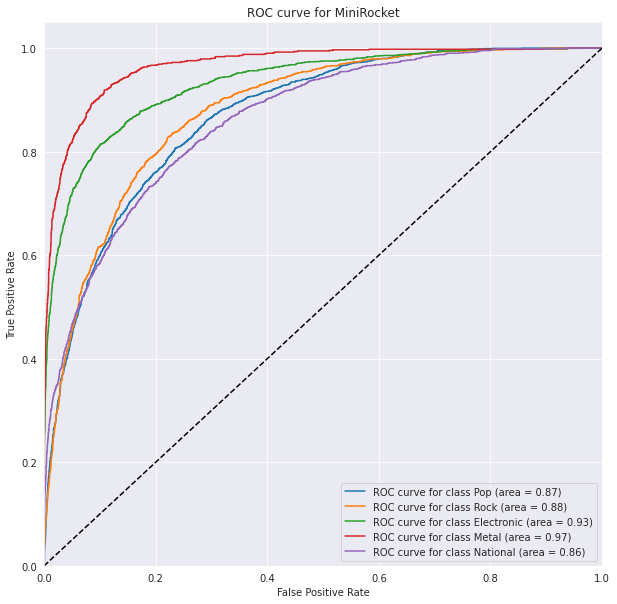

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Binarize the labels
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Predict the probabilities for each class
y_pred_prob = clf.predict_proba(X_test)

# Compute and plot the ROC curves
plt.figure(figsize=(10, 10))
for i, class_ in enumerate(lb.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve for class {} (area = {:.2f})'.format(int_to_genre[class_], roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Feature ranking:
1. feature acousticness (0.094277)
2. feature danceability (0.078928)
3. feature instrumentalness (0.070498)
4. feature Unnamed: 0 (0.063645)
5. feature valence (0.059084)
6. feature energy (0.055352)
7. feature year (0.052824)
8. feature popularity (0.050981)
9. feature speechiness (0.045887)
10. feature loudness (0.043051)
11. feature tempo_confidence (0.041658)
12. feature tempo (0.038998)
13. feature n_beats (0.035910)
14. feature start_of_fade_out (0.035238)
15. feature features_duration_ms (0.034910)
16. feature duration_ms (0.034236)
17. feature liveness (0.030149)
18. feature overall_confidence (0.028290)
19. feature mode_confidence (0.026905)
20. feature key_confidence (0.026026)
21. feature time_signature_confidence (0.023572)
22. feature key (0.017378)
23. feature mode (0.004797)
24. feature explicit (0.004675)
25. feature time_signature (0.002729)


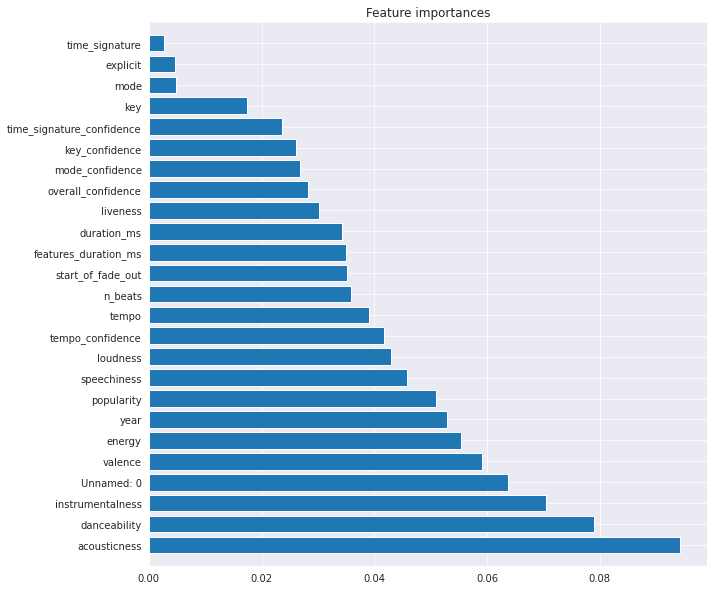

In [5]:
# get the most important features
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking by converting the indices to the feature names
print("Feature ranking:")
feature_names = []
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))
    feature_names.append(X.columns[indices[f]])

# tilt the chart for better readability
plt.figure(figsize=(10, 10))
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), feature_names)
plt.ylim([-1, X.shape[1]])
plt.show()



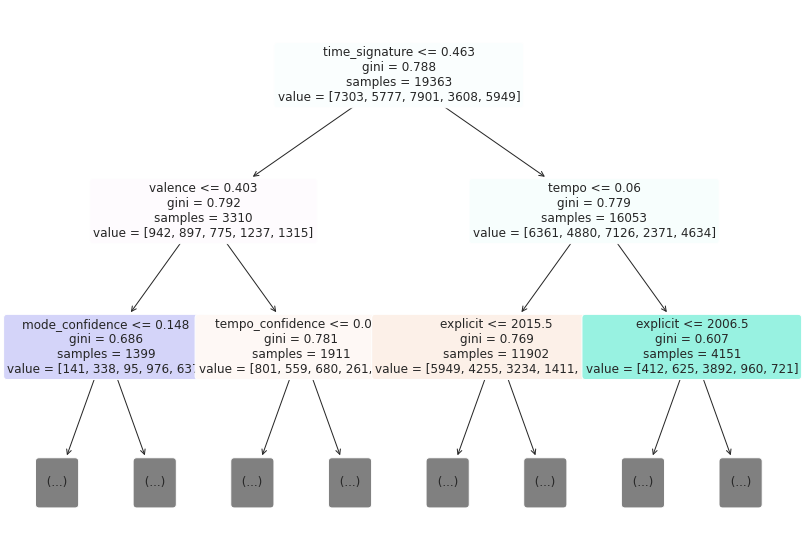

In [24]:
from sklearn.tree import plot_tree

#extract feature names
frame = pd.DataFrame(X_train)
frame.columns = X.columns



plt.figure(figsize=(14,10))
plot_tree(clf.estimators_[0],
          feature_names=feature_names,
          class_names=None,
          filled=True,
          rounded=True,
          fontsize=12,
          max_depth=2)
plt.show()

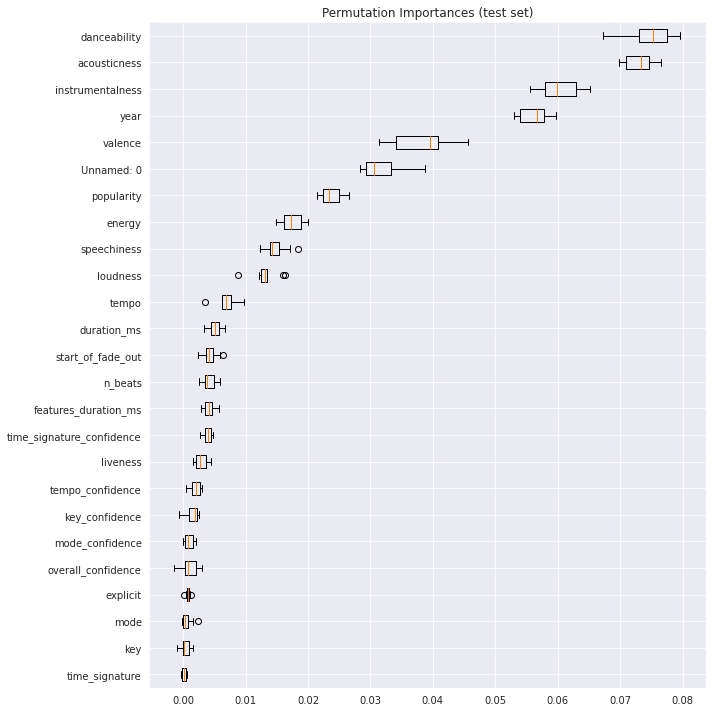

In [6]:
from sklearn.inspection import permutation_importance

#plot the permutation importance
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()



## Bagging

In [10]:
from sklearn.ensemble import BaggingClassifier
rfc = RandomForestClassifier(n_estimators=500,
                             criterion='gini',
                             max_depth=None,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features='log2',
                             random_state=42,
                             n_jobs=4)
clf = BaggingClassifier(estimator=rfc, n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.6641781270464964
F1-score [0.63605353 0.6079789  0.76463324 0.76211454 0.54431863]
              precision    recall  f1-score   support

           0       0.60      0.67      0.64      1803
           1       0.59      0.63      0.61      1467
           2       0.74      0.79      0.76      1962
           3       0.76      0.77      0.76       904
           4       0.66      0.46      0.54      1499

    accuracy                           0.66      7635
   macro avg       0.67      0.66      0.66      7635
weighted avg       0.66      0.66      0.66      7635


## AdaBoost

In [11]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(estimator=rfc, n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy 0.6537000654878847
F1-score [0.61901141 0.59241865 0.76450174 0.75952122 0.52346278]
              precision    recall  f1-score   support

           0       0.57      0.68      0.62      1803
           1       0.58      0.60      0.59      1467
           2       0.74      0.79      0.76      1962
           3       0.75      0.77      0.76       904
           4       0.66      0.43      0.52      1499

    accuracy                           0.65      7635
   macro avg       0.66      0.65      0.65      7635
weighted avg       0.66      0.65      0.65      7635


In [16]:
import catboost as cb


clf = cb.CatBoostClassifier(iterations=1000, depth=8, learning_rate=0.1, loss_function='MultiClass', verbose=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

0:	learn: 1.5190207	total: 12.6ms	remaining: 1m 3s
42:	learn: 0.9059275	total: 619ms	remaining: 1m 11s
84:	learn: 0.8210581	total: 1.69s	remaining: 1m 37s
126:	learn: 0.7663409	total: 2.76s	remaining: 1m 46s
168:	learn: 0.7232196	total: 3.79s	remaining: 1m 48s
210:	learn: 0.6863720	total: 4.78s	remaining: 1m 48s
252:	learn: 0.6555680	total: 5.75s	remaining: 1m 47s
294:	learn: 0.6237769	total: 6.58s	remaining: 1m 44s
336:	learn: 0.5937411	total: 7.17s	remaining: 1m 39s
378:	learn: 0.5654672	total: 7.71s	remaining: 1m 33s
420:	learn: 0.5413255	total: 8.24s	remaining: 1m 29s
462:	learn: 0.5156691	total: 8.77s	remaining: 1m 25s
504:	learn: 0.4912490	total: 9.3s	remaining: 1m 22s
546:	learn: 0.4688447	total: 9.84s	remaining: 1m 20s
588:	learn: 0.4467307	total: 10.4s	remaining: 1m 17s
630:	learn: 0.4269804	total: 10.9s	remaining: 1m 15s
672:	learn: 0.4071046	total: 11.4s	remaining: 1m 13s
714:	learn: 0.3879930	total: 12s	remaining: 1m 11s
756:	learn: 0.3707510	total: 12.5s	remaining: 1m 10s


In [14]:
# grid search catboost

clf = cb.CatBoostClassifier(loss_function='MultiClass', verbose=0)

param_grid = {
    'iterations': [100, 300, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'random_state': [42]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'depth': 8, 'iterations': 500, 'learning_rate': 0.1, 'random_state': 42}
